# Create a raster mask using a shapefile

**What does this notebook do?** 

This notebook demonstrates how to use a shapefile to mask data extracted from an ODC. This notebook imports some Landsat 8 data, generates a shapefile mask, and applies it to the extracted Landsat data.

A shape file containing the polygon you would like to use for the analysis is required. Here we use the ACT reserves [shapefile from data.gov.au](http://actmapi-actgov.opendata.arcgis.com/datasets/df2194f3f13f4521a96c15a0faba04ee_11). This shapefile has been downloaded for you and included in the CSIRO EASI training repostiory in the `work/extras/ACT_Reserves` directory. In the notebook this is available as `/home/jovyan/work/extras/ACT_Reserves`. If you would like to use a different shapefile you can copy into the work directory on your docker host and it will be available to the notebook under `/home/jovyan/work/<where you put it>`

This notebook is adapted from a Digital Earth Australia example by Claire Krause

In [1]:
%pylab notebook

from datacube import Datacube
from datacube.storage import masking

import xarray as xr
import rasterio
import rasterio.features
import geopandas as gp

import os.path

dc = Datacube(app='raster mask')

Populating the interactive namespace from numpy and matplotlib


/home/jovyan/.local/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


## Set up the extraction query

<IPython.core.display.Javascript object>


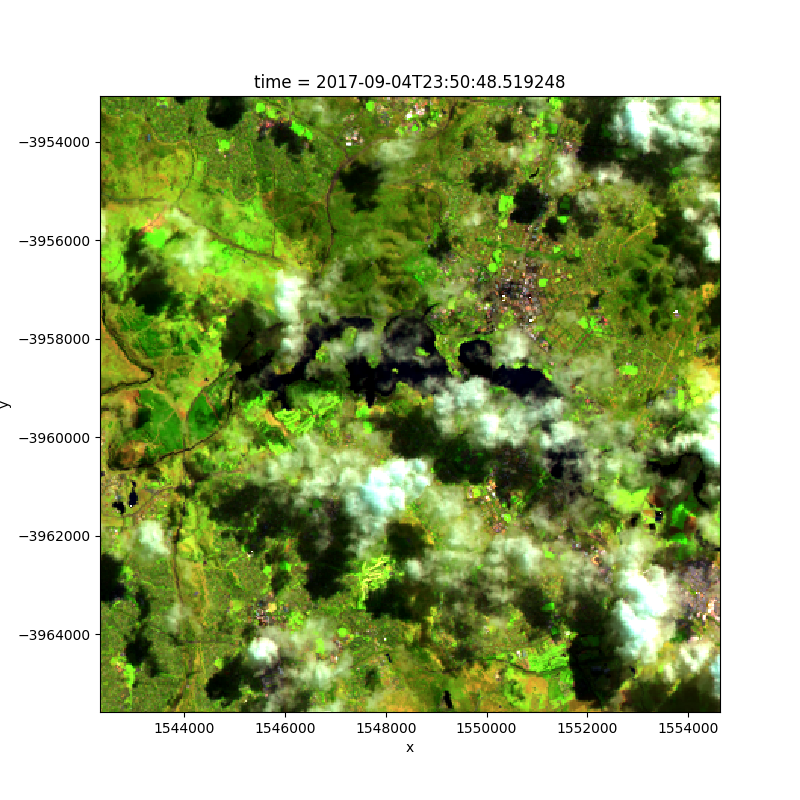

In [2]:
query = {'lat': (-35.25, -35.35),
         'lon': (149.05, 149.17),
         'time': ('2017-09-04', '2017-09-04'),
         'output_crs': 'EPSG:3577',
         'resolution': (-30, 30)} 

data = dc.load(product='ls8_usgs_sr_scene', **query, measurements=['swir1', 'nir', 'green'])

# Set all nodata pixels to `NaN`:
data = masking.mask_invalid_data(data)
# Set all invalid data to `NaN` - valid range for USRS SR is 0 to 10000, but the surface reflectance product can have values just outside this range
# We remove them so the image drawn isn't impacted by them
data = data.where((data >= 0) & (data<=10000))
image_array = data[['swir1', 'nir', 'green']].isel(time=1).to_array()
# Show the image
image_array.plot.imshow(robust=True, figsize=(8, 8))

## Read in the shapefile you would like to use to mask the Landsat data

For this example, we use the polygon dataset of [ACT Reserves](http://actmapi-actgov.opendata.arcgis.com/datasets/df2194f3f13f4521a96c15a0faba04ee_11). 

In [3]:
shape_file = os.path.expanduser('~/work/extras/ACT_Reserves/ACT_Reserves.shp')

In [4]:
shp = gp.read_file(shape_file)

# Reproject coordinate system of shape file
shp = shp.to_crs({'init': 'epsg:3577'})

### Iterate over each of the polygons, and put a '1' in the mask raster that corresponds to the footprint of each polygon

In [5]:
mask = rasterio.features.rasterize(((feature['geometry'], 1) for feature in shp.iterfeatures()),
                                   out_shape=data.isel(time=0).green.shape,
                                   transform=data.green.affine
                                  )

In [6]:
# Convert the numpy array to a DataArray
mask = xr.DataArray(mask, coords=(data.y, data.x))

<IPython.core.display.Javascript object>


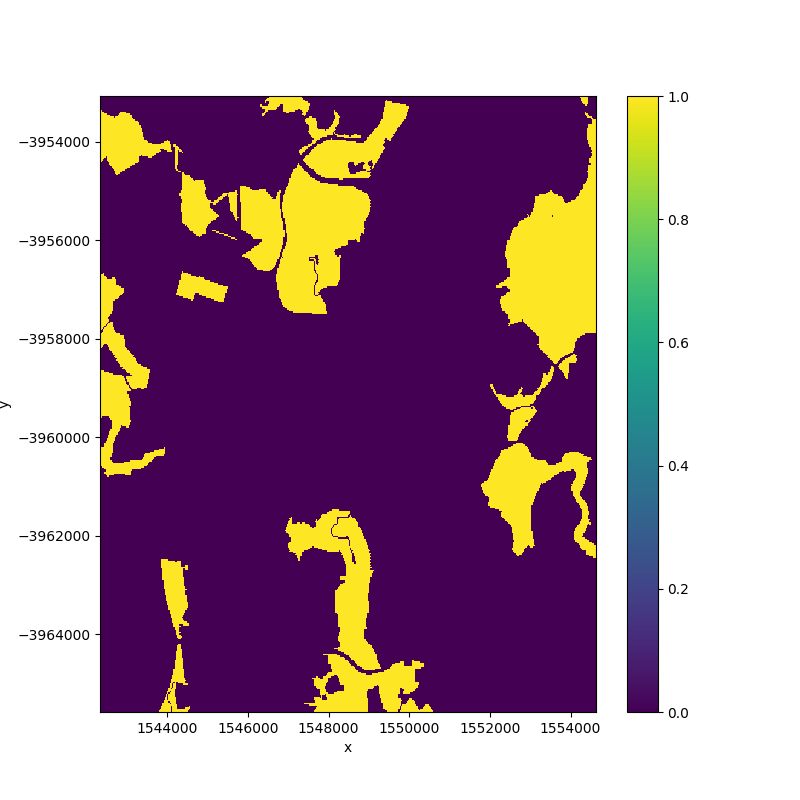

In [7]:
mask.plot(figsize=(8, 8))

## Apply the mask to the Landsat data and plot

In [8]:
# Data * mask = data or nan
MaskedData = data.where(mask)

<IPython.core.display.Javascript object>


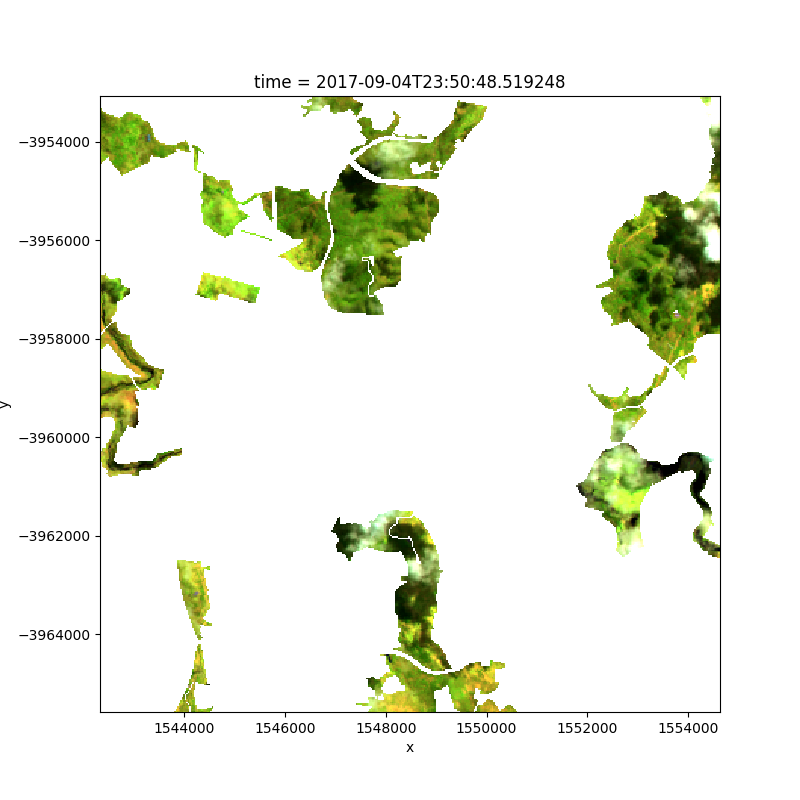

In [9]:
image_array = MaskedData[['swir1', 'nir', 'green']].isel(time=1).to_array()
# Show the image
image_array.plot.imshow(robust=True, figsize=(8, 8))